<a href="https://colab.research.google.com/github/African-Quant/WQU_MScFE_Capstone_Grp9/blob/master/feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from fastbook import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from pyfolio.timeseries import perf_stats 
from pyfolio import create_simple_tear_sheet

In [2]:
import os
import re     
import random
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

import warnings
warnings.filterwarnings('ignore')

In [3]:
pairs = ['AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD', 'AUDUSD', 'CAD', 'CADCHF', 
        'CADJPY', 'CHF', 'CHFJPY', 'EURAUD', 'EURCAD', 'EURCHF', 'EURGBP', 
        'EURJPY', 'EURNZD', 'EURUSD', 'GBPAUD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 
        'GBPNZD', 'GBPUSD', 'JPY', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'NZDUSD']

def get_data(pair):
        ''' Retrieves and prepares the data.
        '''
        url = f'https://raw.githubusercontent.com/African-Quant/WQU_MScFE_Capstone_Grp9/master/Datasets/{pair}%3DX.csv'
        raw = pd.read_csv(url)
        raw = pd.DataFrame(raw).drop(['Adj Close', 'Volume'], axis=1)
        raw.iloc[:,0] = pd.to_datetime(raw.iloc[:,0])
        raw.set_index('Date', inplace=True)
        return raw

In [4]:
d = {a:b for a, b in enumerate(pairs)}
print(d)

{0: 'AUDCAD', 1: 'AUDCHF', 2: 'AUDJPY', 3: 'AUDNZD', 4: 'AUDUSD', 5: 'CAD', 6: 'CADCHF', 7: 'CADJPY', 8: 'CHF', 9: 'CHFJPY', 10: 'EURAUD', 11: 'EURCAD', 12: 'EURCHF', 13: 'EURGBP', 14: 'EURJPY', 15: 'EURNZD', 16: 'EURUSD', 17: 'GBPAUD', 18: 'GBPCAD', 19: 'GBPCHF', 20: 'GBPJPY', 21: 'GBPNZD', 22: 'GBPUSD', 23: 'JPY', 24: 'NZDCAD', 25: 'NZDCHF', 26: 'NZDJPY', 27: 'NZDUSD'}


In [5]:
# ATR
def eATR(df1,n=14):
    """This calculates the Average True Range of of a dataframe of the open,
    high, low, and close data of an instrument"""

    df = df1[['Open',	'High',	'Low',	'Close']].copy()
    # True Range
    df['TR'] = 0
    for i in range(len(df)):
      try:
        df.iloc[i, 4] = max(df.iat[i,1] - df.iat[i,2],
                         abs(df.iat[i,1] - df.iat[i-1,3]),
                         abs(df.iat[i,2] - df.iat[i-1,3]))
      except ValueError:
        pass

    # eATR
    df['eATR'] = df['TR'].ewm(span=n, adjust=False).mean()
           
    return df['eATR']

In [6]:
data = get_data(pairs[0])
data.head(1)

,Open,High,Low,Close
Date,,,,
2003-12-01,0.93995,0.94965,0.93789,0.94888


In [7]:
def ssl(df1):
  df = df1.copy()
  df['smaHigh'] = df['High'].rolling(window=10).mean()
  df['smaLow'] = df['Low'].rolling(window=10).mean()
  df['hlv'] = 0
  df['hlv'] = np.where(df['Close'] > df['smaHigh'],1,np.where(df['Close'] < df['smaLow'],-1,df['hlv'].shift(1)))
  df['sslDown'] = np.where(df['hlv'] < 0, df['smaHigh'], df['smaLow'])
  df['sslUp'] = np.where(df['hlv'] < 0, df['smaLow'], df['smaHigh'])
  df['sslPosition'] = np.where(df['Close'] > df['sslUp'], 1,
                               np.where(df['Close'] < df['sslDown'], -1, 0))
  return df[['sslDown', 'sslUp', 'sslPosition']]

In [8]:
# Waddah Attar
def WAE(df1):
  df = df1.copy()

  # EMA
  long_ema = df.loc[:,'Close'].ewm(span=40, adjust=False).mean()
  short_ema = df.loc[:,'Close'].ewm(span=20, adjust=False).mean()

  # MACD
  MACD = short_ema - long_ema
  
  # bBands
  sma20 = df.loc[:,'Close'].rolling(window=20).mean()  # 20 SMA
    
  stddev = df.loc[:,'Close'].rolling(window=20).std() # 20 STDdev
  lower_band = sma20 - (2 * stddev)
  upper_band = sma20 + (2 * stddev)

  #Waddah Attar
  t1 = (MACD - MACD.shift(1))* 150
  #t2 = MACD.shift(2) - MACD.shift(3)
  df['e1'] = upper_band - lower_band
  df['e2'] = -1 *df['e1']
  #e2 = upper_band.shift(1) - lower_band.shift(1)

  df['trendUp'] = np.where(t1 > 0, t1, 0)
  df['trendDown'] =  np.where(t1 < 0, t1, 0)

  df['waePosition'] = np.where(df['trendUp'] > 0, 1,
                               np.where(df['trendDown'] < 0, -1, 0))
  
  
  return df[['e1','e2','trendUp', 'trendDown', 'waePosition']]


In [9]:
def lag_feat(data1):
  data = data1.copy()
  lags = 8
  cols = []
  for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['ret'].shift(lag)
    cols.append(col)
  return data[cols]

In [10]:

def datepart_feat(df0, colname = 'Date'):
    """This function adds some common pandas date parts like 'year',
        'month' etc as features to a dataframe
    """
    df = df0.copy()
    df.reset_index(inplace=True)
    df1 = df.loc[:,colname]
    nu_feats = ['Year', 'Month', 'Day', 'Dayofweek', 'daysinmonth',
            'Dayofyear', 'Is_month_end', 'Is_month_start', 'quarter',
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start']
    
    targ_pre = re.sub('[Dd]ate$', '', colname)
    for n in nu_feats:
        df[targ_pre+n] = getattr(df1.dt,n.lower())

    df[targ_pre+'week'] = df1.dt.isocalendar().week.astype(np.int64)
    df[targ_pre+'Elapsed'] = df1.astype(np.int64) // 10**9
    nu_feats.extend(['week', 'Elapsed'])
    df.set_index(colname, inplace=True)
    return df[nu_feats]

In [11]:
def gen_feat(pair):
  df0 = get_data(pair).iloc[-4200:,]
  df0['ret'] = df0['Close'].pct_change()
  df0['dir'] = np.sign(df0['ret'])
  eATR_ = eATR(df0).shift(1)
  wae = WAE(df0).shift(1)
  ssl1 = ssl(df0).shift(1)
  datepart = datepart_feat(df0)
  lags = lag_feat(df0)
  return pd.concat([df0,  eATR_, wae, ssl1, datepart, lags], axis=1).dropna()

In [12]:
dataset = gen_feat(pairs[0])
dataset.drop(['Open', 'High', 'Low'], axis=1, inplace=True)
dataset.tail()

,Close,ret,dir,eATR,e1,e2,trendUp,trendDown,waePosition,sslDown,sslUp,sslPosition,Year,Month,Day,Dayofweek,daysinmonth,Dayofyear,Is_month_end,Is_month_start,quarter,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,week,Elapsed,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-23,0.969710,0.002782,1.0,0.007199,0.044662,-0.044662,0.0,-0.043324,-1.0,0.966522,0.972114,0.0,2021,3,23,1,31,82,False,False,1,False,False,False,False,12,1616457600,-0.001454,0.000856,0.004047,-0.002896,-0.001375,-0.008208,0.000759,-0.000385
2021-03-24,0.957383,-0.012712,-1.0,0.007105,0.041319,-0.041319,0.0,-0.016879,-1.0,0.966182,0.971627,0.0,2021,3,24,2,31,83,False,False,1,False,False,False,False,12,1616544000,0.002782,-0.001454,0.000856,0.004047,-0.002896,-0.001375,-0.008208,0.000759
2021-03-25,0.954794,-0.002704,-1.0,0.008066,0.040934,-0.040934,0.0,-0.098690,-1.0,0.969797,0.964505,-1.0,2021,3,25,3,31,84,False,False,1,False,False,False,False,12,1616630400,-0.012712,0.002782,-0.001454,0.000856,0.004047,-0.002896,-0.001375,-0.008208
2021-03-26,0.956957,0.002265,1.0,0.007584,0.039112,-0.039112,0.0,-0.100779,-1.0,0.967594,0.962348,-1.0,2021,3,26,4,31,85,False,False,1,False,False,False,False,12,1616716800,-0.002704,-0.012712,0.002782,-0.001454,0.000856,0.004047,-0.002896,-0.001375
2021-03-29,0.962240,0.005521,1.0,0.007232,0.037237,-0.037237,0.0,-0.068994,-1.0,0.965862,0.961142,-1.0,2021,3,29,0,31,88,False,False,1,False,False,False,False,13,1616976000,0.002265,-0.002704,-0.012712,0.002782,-0.001454,0.000856,0.004047,-0.002896


In [13]:
cols = list(dataset.columns)

print(cols)

['Close', 'ret', 'dir', 'eATR', 'e1', 'e2', 'trendUp', 'trendDown', 'waePosition', 'sslDown', 'sslUp', 'sslPosition', 'Year', 'Month', 'Day', 'Dayofweek', 'daysinmonth', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'quarter', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'week', 'Elapsed', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8']


In [14]:
feats = cols[2:]

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2976 entries, 2005-03-22 to 2017-03-31
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Close             2976 non-null   float64
 1   ret               2976 non-null   float64
 2   dir               2976 non-null   float64
 3   eATR              2976 non-null   float64
 4   e1                2976 non-null   float64
 5   e2                2976 non-null   float64
 6   trendUp           2976 non-null   float64
 7   trendDown         2976 non-null   float64
 8   waePosition       2976 non-null   float64
 9   sslDown           2976 non-null   float64
 10  sslUp             2976 non-null   float64
 11  sslPosition       2976 non-null   float64
 12  Year              2976 non-null   int64  
 13  Month             2976 non-null   int64  
 14  Day               2976 non-null   int64  
 15  Dayofweek         2976 non-null   int64  
 16  daysinmonth       2976 n

In [16]:
df_train = dataset.iloc[:-1000,:]
train = df_train.copy()
df_test = dataset.iloc[-1000:,:]
test = df_test.copy()

In [18]:
dep_var = 'dir'

### Using *FastAI* and *Random Forest* to Predict Market Direction.

In [19]:
procs = [Categorify, FillMissing]

In [20]:
cond = df_train.Year<2015

In [21]:
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [22]:
splits = (list(train_idx),list(valid_idx))

In [23]:
cont,cat = cont_cat_split(train[feats], 1, dep_var=dep_var)

In [24]:
to = TabularPandas(train[feats], procs, cat, cont, y_names=dep_var, splits=splits)

In [25]:
len(to.train),len(to.valid)

(2389, 587)

In [26]:
to.show(3)

,Year,Month,Day,Dayofweek,daysinmonth,Dayofyear,Is_month_end,Is_month_start,quarter,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,week,Elapsed,eATR,e1,e2,trendUp,trendDown,waePosition,sslDown,sslUp,sslPosition,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,dir
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-03-22,2005,3,22,1,31,81,False,False,1,False,False,False,False,12,1111449600,0.008758,0.042487,-0.042487,0.0,-0.054178,-1.0,0.960269,0.951394,-1.0,-0.003911,0.001260,-0.003640,0.00320,0.001724,-0.006288,0.006676,-0.004490,-1.0
2005-03-23,2005,3,23,2,31,82,False,False,1,False,False,False,False,12,1111536000,0.009175,0.046538,-0.046538,0.0,-0.106762,-1.0,0.957847,0.948785,-1.0,-0.009567,-0.003911,0.001260,-0.00364,0.003200,0.001724,-0.006288,0.006676,-1.0
2005-03-24,2005,3,24,3,31,83,False,False,1,False,False,False,False,12,1111622400,0.009111,0.048157,-0.048157,0.0,-0.101138,-1.0,0.955513,0.947063,-1.0,-0.001977,-0.009567,-0.003911,0.00126,-0.003640,0.003200,0.001724,-0.006288,-1.0


In [27]:
to.items.head(2)

,dir,eATR,e1,e2,trendUp,trendDown,waePosition,sslDown,sslUp,sslPosition,Year,Month,Day,Dayofweek,daysinmonth,Dayofyear,Is_month_end,Is_month_start,quarter,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,week,Elapsed,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-03-22,-1.0,0.008758,0.042487,-0.042487,0.0,-0.054178,-1.0,0.960269,0.951394,-1.0,1,3,22,2,4,81,1,1,1,1,1,1,1,12,1,-0.003911,0.001260,-0.00364,0.00320,0.001724,-0.006288,0.006676,-0.004490
2005-03-23,-1.0,0.009175,0.046538,-0.046538,0.0,-0.106762,-1.0,0.957847,0.948785,-1.0,1,3,23,3,4,82,1,1,1,1,1,1,1,12,2,-0.009567,-0.003911,0.00126,-0.00364,0.003200,0.001724,-0.006288,0.006676


In [28]:
conti,categ = cont_cat_split(test[feats], 1, dep_var=dep_var)

In [29]:
to_t = TabularPandas(test[feats], procs, categ, conti, y_names=dep_var, splits=None)

In [30]:
save_pickle('to.pkl',to)

In [31]:
to = load_pickle('to.pkl')

In [32]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [33]:
def rfc(xs, y, n_estimators=40, max_samples=2000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [34]:
m = rfc(xs, y);

In [35]:
valid_pred = m.predict(valid_xs)

In [36]:
valid_acc = accuracy_score(valid_y, valid_pred)
print(f'Validation Accuracy: {valid_acc}')

Validation Accuracy: 0.47018739352640543


In [37]:
xs_t,y_t =  to_t.train.xs, to_t.train.ys.values.ravel()

In [38]:
test_pred = m.predict(test[feats[1:]])

In [39]:
test_acc = accuracy_score(test['dir'], test_pred)
print(f'Test set Accuracy: {test_acc}')

Test set Accuracy: 0.486


In [40]:
test['prediction'] = test_pred

In [41]:
test['prediction'].value_counts()

-1.0    902
 1.0     98
Name: prediction, dtype: int64

In [42]:
hits = np.sign(test['ret'] * test['prediction']).value_counts()
hits

-1.0    513
 1.0    486
 0.0      1
dtype: int64

In [43]:
test['strategy'] = (test['prediction'] * test['ret'])

In [44]:
test[['ret', 'strategy']].sum().apply(np.exp)

ret         0.950590
strategy    0.850615
dtype: float64

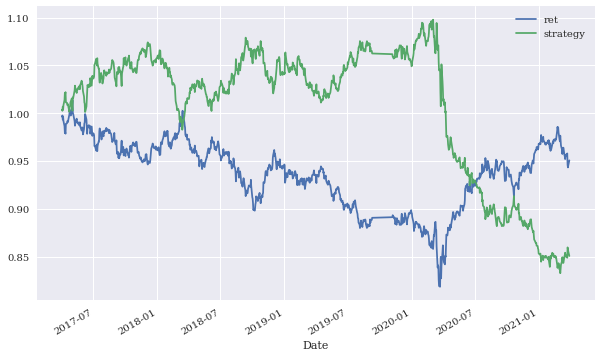

In [45]:
test[['ret', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_2.png')

In [46]:
def feat_imp(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False) 

In [47]:
f_i = feat_imp(m, xs)
f_i[:30]

,cols,imp
29,lag_6,0.069783
30,lag_7,0.069406
31,lag_8,0.064313
28,lag_5,0.062738
15,eATR,0.061087
26,lag_3,0.059569
24,lag_1,0.058525
27,lag_4,0.056856
25,lag_2,0.053143
14,Elapsed,0.052961


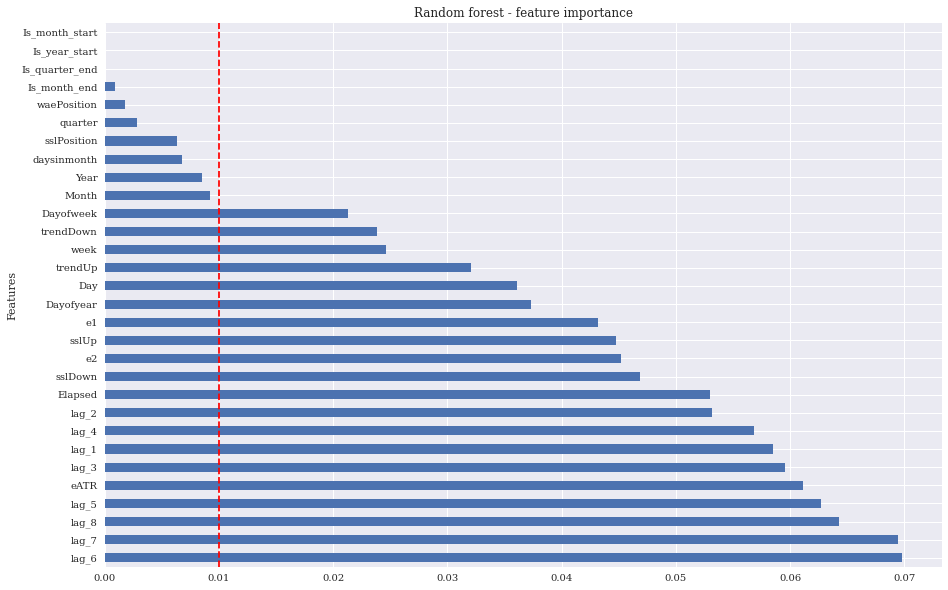

In [48]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(15,10),title='Random forest - feature importance', 
                   xlabel='Features', legend=False), plt.axvline(0.01, color='r', ls='--')

plot_fi(f_i[:30]);

In [49]:
to_keep = f_i[f_i.imp>0.01].cols
len(to_keep)

20

In [50]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [51]:
m = rfc(xs_imp, y)

In [52]:
valid_pred = m.predict(valid_xs_imp)

In [53]:
valid_acc = accuracy_score(valid_y, valid_pred)
print(f'Validation Accuracy: {valid_acc}')

Validation Accuracy: 0.5008517887563884


In [54]:
test_pred = m.predict(test[to_keep])

In [55]:
test_acc = accuracy_score(test['dir'], test_pred)
print(f'Test set Accuracy: {test_acc}')

Test set Accuracy: 0.506


In [56]:
len(xs.columns), len(xs_imp.columns)

(32, 20)

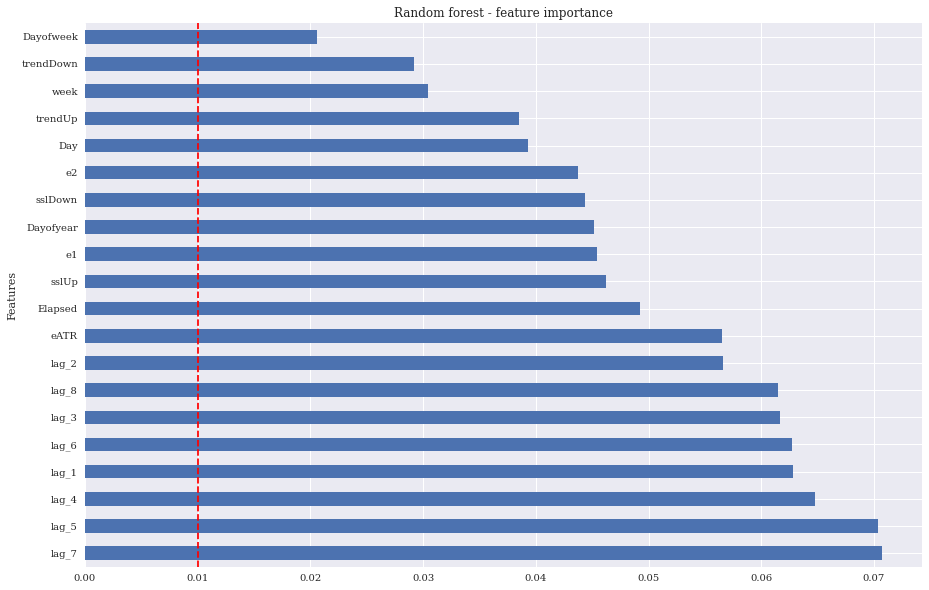

In [57]:
plot_fi(feat_imp(m, xs_imp));

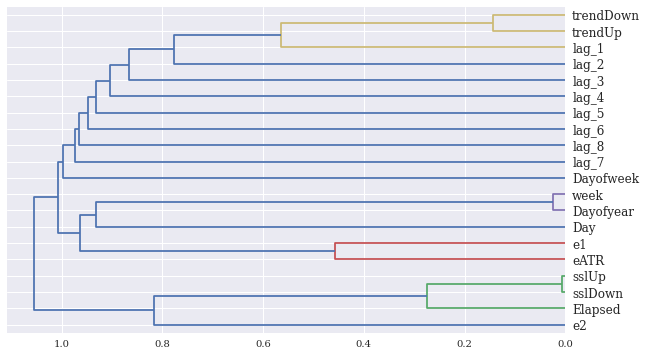

In [58]:
cluster_columns(xs_imp)

In [59]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15,
        max_samples=2000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [60]:
get_oob(xs_imp)

0.5023022185014651

In [61]:
print(list(xs_imp.columns))

['lag_6', 'lag_7', 'lag_8', 'lag_5', 'eATR', 'lag_3', 'lag_1', 'lag_4', 'lag_2', 'Elapsed', 'sslDown', 'e2', 'sslUp', 'e1', 'Dayofyear', 'Day', 'trendUp', 'week', 'trendDown', 'Dayofweek']


In [62]:
# {c:get_oob(xs_imp.drop(c, axis=1)) for c in (
#     'Month', 'Dayofyear', 'sslUp', 'sslDown')}

In [63]:
# get_oob(xs_imp.drop('Month', axis=1))

In [64]:
test_imp = test[to_keep]

In [65]:
xs_final = xs_imp#.drop('Month', axis=1)
valid_xs_final = valid_xs_imp#.drop('Month', axis=1)
test_imp_final = test_imp#.drop('Month', axis=1)

In [66]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('valid_xs_final.pkl', valid_xs_final)
save_pickle('test_imp_final.pkl', test_imp_final)

In [67]:
xs_final = load_pickle('xs_final.pkl')
valid_xs_final = load_pickle('valid_xs_final.pkl')
test_imp_final = load_pickle('test_imp_final.pkl')

In [68]:
m = rfc(xs_final, y)

In [69]:
train_pred = m.predict(xs_final)
train_acc = accuracy_score(y, train_pred)
print(f'Train Set Accuracy: {train_acc}')
print(confusion_matrix(y, train_pred))
print(classification_report(y, train_pred))


Train Set Accuracy: 0.9790707408957723
[[1137    0   25]
 [   6    0    8]
 [  11    0 1202]]
              precision    recall  f1-score   support

        -1.0       0.99      0.98      0.98      1162
         0.0       0.00      0.00      0.00        14
         1.0       0.97      0.99      0.98      1213

    accuracy                           0.98      2389
   macro avg       0.65      0.66      0.65      2389
weighted avg       0.97      0.98      0.98      2389



In [70]:
valid_pred = m.predict(valid_xs_final)
valid_acc = accuracy_score(valid_y, valid_pred)
print(f'Validation Set Accuracy: {valid_acc}')
print(confusion_matrix(valid_y, valid_pred))
print(classification_report(valid_y, valid_pred))

Validation Set Accuracy: 0.4991482112436116
[[175 101]
 [193 118]]
              precision    recall  f1-score   support

        -1.0       0.48      0.63      0.54       276
         1.0       0.54      0.38      0.45       311

    accuracy                           0.50       587
   macro avg       0.51      0.51      0.49       587
weighted avg       0.51      0.50      0.49       587



In [71]:
test_pred = m.predict(test_imp_final)
test_acc = accuracy_score(test['dir'], test_pred)
print(f'Test Set Accuracy: {test_acc}')
print(confusion_matrix(test['dir'], test_pred))
print(classification_report(test['dir'], test_pred))

Test Set Accuracy: 0.5
[[193   0 305]
 [  0   0   1]
 [194   0 307]]
              precision    recall  f1-score   support

        -1.0       0.50      0.39      0.44       498
         0.0       0.00      0.00      0.00         1
         1.0       0.50      0.61      0.55       501

    accuracy                           0.50      1000
   macro avg       0.33      0.33      0.33      1000
weighted avg       0.50      0.50      0.49      1000



Start date,2017-04-03
End date,2021-03-29
Total months,47
,Backtest
Annual return,-1.6%
Cumulative returns,-6.4%
Annual volatility,7.2%
Sharpe ratio,-0.19
Calmar ratio,-0.07
Stability,0.72
Max drawdown,-22.5%


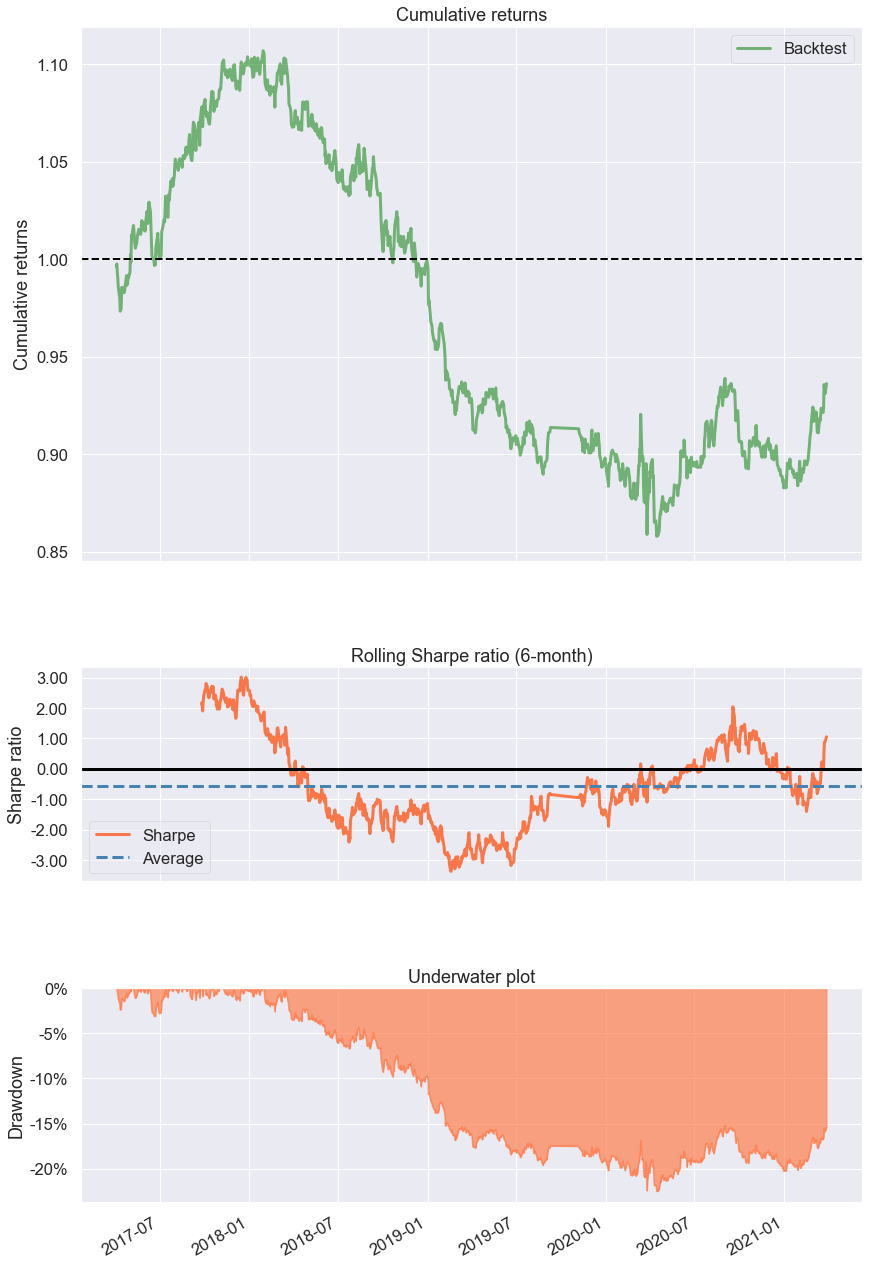

In [73]:
create_simple_tear_sheet(df_test['ret']*test_pred)